#  Final Project Data 607

This notebook examines the kaggle covid-19 public dataset in an attempt to extract text from the articles provided to answer the following questions:

<b>Question 1:</b> What are Covid-19 Risk-Factors?
<br>
<b>Question 2:</b> What has been published about ethical and social science considerations?
<br>
<b>Question 3:</b> What is known about transmission, incubation, and environmental stability?


The dataset is text data from medical journales and articles about on codvid-19. All the data is stored locally for use in the below funcitons becuase it is too big to store on github.

## Load Dependencies

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
# EDA packages
import pandas as pd
import numpy as np
import re
import json
from zipfile import ZipFile
import collections

# NLP Packages
import requests as r
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
from gensim.models import Word2Vec
from sklearn import utils
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

# Data Vziz Packages
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
%matplotlib inline 

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kevin.potter@ibm.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Metadata 

Investigate the metadata csv. This is a table that provides various info about each article in the dataset including information to a allow of lookup in the zip files, data to web scrape the articles, title, author, and a text snippet from the article.

In [29]:
catalog = pd.read_csv('metadata.csv')
catalog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44220 entries, 0 to 44219
Data columns (total 15 columns):
sha                            28462 non-null object
source_x                       44220 non-null object
title                          43996 non-null object
doi                            40750 non-null object
pmcid                          23319 non-null object
pubmed_id                      22943 non-null float64
license                        44220 non-null object
abstract                       35806 non-null object
publish_time                   34197 non-null object
authors                        41074 non-null object
journal                        33173 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1767 non-null object
has_full_text                  44220 non-null bool
full_text_file                 32829 non-null object
dtypes: bool(1), float64(2), object(12)
memory usage: 4.8+ MB


In [30]:
#Quick EDA 
source_dist = pd.DataFrame(catalog.source_x.value_counts()).reset_index().rename(columns = {'index':'Source','source_x':'Count'})
source_dist['%'] = source_dist['Count'].apply(lambda x: x/source_dist['Count'].sum())
#7 sources with 50% coming from PMC 
source_dist

,Source,Count,%
0,PMC,22309,0.504500
1,Elsevier,19471,0.440321
2,WHO,1154,0.026097
3,biorxiv,605,0.013682
4,medrxiv,445,0.010063
5,CZI,153,0.003460
6,PMC_new,83,0.001877


In [31]:
journal_dist = pd.DataFrame(catalog.journal.value_counts()).reset_index().rename(columns = {'index':'Journal','journal':'Count'})
journal_dist['%'] = journal_dist['Count'].apply(lambda x: x/journal_dist['Count'].sum())
#20% articles are withing top 10 journals. PLos Being the top 
journal_dist[0:10]

,Journal,Count,%
0,PLoS One,1562,0.047086
1,Virology,816,0.024598
2,Emerg Infect Dis,749,0.022579
3,The Lancet,580,0.017484
4,Viruses,554,0.016700
5,Virus Research,528,0.015917
6,Veterinary Microbiology,486,0.014650
7,Sci Rep,486,0.014650
8,Vaccine,450,0.013565
9,Journal of Virological Methods,416,0.012540


In [32]:
covidence_count = len(catalog[catalog['WHO #Covidence'].isnull() == False])
# 4% (1767) of the articles are labeled as covidence (potential starting point?)
covidence_count, covidence_count/len(catalog) 

(1767, 0.03995929443690638)

In [33]:
fullt_count = len(catalog[catalog['has_full_text'] == True])
#64% of Records have full text...
fullt_count, fullt_count/len(catalog) 

(28462, 0.643645409317051)

If there is no abstract we use the title

In [34]:
catalog['abstract'] = catalog.abstract.fillna(catalog.title)

## Subset Data to Kaggle Questions

Filter out articles that do not have full text. SHA column is the name of the json file that is used to extract the body of an article from the corresponing .zip file. When doing the key word search we use variations of the key word to include all relevant articles.

In [35]:
#Kick out articles with no SHA (Temporary)
catalog = catalog[catalog['sha'].isnull() == False]

# Filter out non full-text files
covids = '(covid|Covid|COVID|Corona|corona)'

#Filter down to covid specific articles 
covid_filter = catalog.iloc[[i for i,x in enumerate(catalog['abstract']) if len(re.findall(covids,str(x))) > 0],:]

**Unpack zip file fucntion**

This function is for extracting the body of text for relvant articles

In [36]:
def get_text(paper, text_key):
    body_dict = collections.defaultdict(list)
    for rec in paper[text_key]:
        body_dict[rec['section']].append(rec['text'])
    
    body = ''
    for section, text_sections in body_dict.items():
        body += section + '\n\n'
        for text in text_sections:
            body += text + '\n\n'
    return body

In [37]:
#Setting up the ZipFile objects
full_text_file_dict = {} 
full_text_file_dict['biorxiv_medrxiv'] = ZipFile('biorxiv_medrxiv.zip', 'r')
full_text_file_dict['custom_license'] = ZipFile('custom_license.zip', 'r')
full_text_file_dict['noncomm_use_subset'] = ZipFile('noncomm_use_subset.zip', 'r')
full_text_file_dict['comm_use_subset'] = ZipFile('comm_use_subset.zip', 'r')

**Web Scrape Functions**

These functions a re used to get the url where the aritlce is located and then extract the text from the url using beautiful soup. and requests.

In [38]:
def get_url(doi):
    url = ''
    headers = r.utils.default_headers()
    headers['User-Agent']  = 'Firefox/73.0.1'
    try:
        page = r.get('https://doi.org/' + doi , headers= headers)
        if page.status_code == 200:
            url = page.url
    except:
        pass
    return url


def who_web_scrape(url):
    headers = r.utils.default_headers()
    headers['User-Agent']  = 'Firefox/73.0.1'
    page = r.get(url, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    all_p = soup.find_all('p')
    body = ''
    for p in all_p:
        body += p.text
    return body

Below cells scrape the data from the world health articles to use for modeling, uncomment to run and save the resulting data. 

In [39]:
# world_health_data = catalog[catalog['source_x'] == 'WHO']
# world_health_data['url'] = world_health_data['doi'].apply(lambda x: get_url(x))
# world_health_data['body'] = world_health_data['url'].apply(lambda x: who_web_scrape(x))
# world_health_data.to_csv('world_health_data.csv')

## Question: What do we know about COVID-19 risk factors?

Change keyword search to suit question

In [40]:
risk_keywords = '(Risk Factor|risk factor|risk-factor|Risk-Factor)'

#filter down to "risk factor" aritcles 
riskf_filter = covid_filter.iloc[[i for i,x in enumerate(covid_filter['abstract']) if len(re.findall(risk_keywords,str(x))) > 0],:]

In [41]:
riskf_keys = riskf_filter[['sha','full_text_file']]
riskf_keys['address'] = riskf_keys['full_text_file'] +'/'+riskf_keys['sha']+'.json'

In [42]:
risk_factor = []

for i in range(0,len(riskf_keys)): 
    full_t_f  = riskf_keys['full_text_file'].iloc[i]
    zipObj = full_text_file_dict[full_t_f]
    address = riskf_keys['address'].iloc[i]
    try: paper = zipObj.open(address).read()
    except:continue
    body = get_text(json.loads(paper),text_key='body_text')
    sentences = nltk.tokenize.sent_tokenize(body)
    per_art = ''
    for sent in sentences:
        if any(word in  sent for word in risk_keywords):
            per_art += sent
    if per_art == '':
        pass
    else:
        risk_factor.append(per_art)

## Question: What has been published about ethical and social science considerations?

Change keyword search to suit question

In [43]:
#Filter out non full-text files
ethical_keywords = '(ethics|Ethics|Ethical|ethical|Social|social)'

#filter down to "ethical/social" aritcles 
ethical_filter = covid_filter.iloc[[i for i,x in enumerate(covid_filter['abstract']) if len(re.findall(ethical_keywords,str(x))) > 0],:]

In [44]:
ethical_keys = ethical_filter[['sha','full_text_file']]
ethical_keys['address'] = ethical_keys['full_text_file'] +'/'+ethical_keys['sha']+'.json'

In [45]:
ethical = []
for i in range(0,len(ethical_keys)): 
    full_t_f  = ethical_keys['full_text_file'].iloc[i]
    zipObj = full_text_file_dict[full_t_f]
    address = ethical_keys['address'].iloc[i]
    try: paper = zipObj.open(address).read()
    except:continue
    body = get_text(json.loads(paper),text_key='body_text')
    sentences = nltk.tokenize.sent_tokenize(body)
    per_art = ''
    for sent in sentences:
        if any(word in  sent for word in ethical_keywords):
            per_art += sent
    if per_art == '':
        pass
    else:
        ethical.append(per_art)

## Question: What is known about transmission, incubation, and environmental stability?

Change keyword search to suit question

In [46]:
transmission_keywords = '(transmission|Transmission|Incubation|incubation|incubation period|environmental stability|serial interval| diagnostics)'

#filter down to "ethical/social" aritcles 
transmission_filter = covid_filter.iloc[[i for i,x in enumerate(covid_filter['abstract']) if len(re.findall(transmission_keywords,str(x))) > 0],:]

In [47]:
##Make DataFrame of the Addreses 
transmission_keys = transmission_filter[['sha','full_text_file']]
transmission_keys['address'] = transmission_keys['full_text_file'] +'/'+transmission_keys['sha']+'.json'

In [48]:
transmission = []
#There are ~13 articles that weren't found... 
for i in range(0,len(transmission_keys)): 
    full_t_f  = transmission_keys['full_text_file'].iloc[i]
    zipObj = full_text_file_dict[full_t_f]
    address = transmission_keys['address'].iloc[i]
    try: paper = zipObj.open(address).read()
    except:continue
    body = get_text(json.loads(paper),text_key='body_text')
    sentences = nltk.tokenize.sent_tokenize(body)
    per_art = ''
    for sent in sentences:
        if any(word in  sent for word in transmission_keywords):
            per_art += sent
    if per_art == '':
        pass
    else:
        transmission.append(per_art)

## NLP Functions

The below functions clean and tokenize the collected text from above

In [49]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [50]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [51]:
clean_tokens_risk = [tokenize_text(cleanText(x)) for x in risk_factor]
risk_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(clean_tokens_risk)]

In [52]:
clean_tokens_ethical = [tokenize_text(cleanText(x)) for x in ethical]
ethics_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(clean_tokens_ethical)]

In [53]:
clean_tokens_transmission = [tokenize_text(cleanText(x)) for x in transmission]
transmission_documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(clean_tokens_transmission)]

## Train the Models

The below function and cells fit and train doc2vec models from the genism library

In [54]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return regressors

In [55]:
model_risk = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_risk.build_vocab([x for x in risk_documents])
for epoch in range(30):
    model_risk.train(utils.shuffle([x for x in risk_documents]), total_examples=len(risk_documents), epochs=1)
    model_risk.alpha -= 0.002
    model_risk.min_alpha = model_risk.alpha

In [56]:
model_ethics = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_ethics.build_vocab([x for x in ethics_documents])
for epoch in range(30):
    model_ethics.train(utils.shuffle([x for x in ethics_documents]), total_examples=len(ethics_documents), epochs=1)
    model_ethics.alpha -= 0.002
    model_ethics.min_alpha = model_ethics.alpha

In [57]:
model_transmission = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0)
model_transmission.build_vocab([x for x in transmission_documents])
for epoch in range(30):
    model_transmission.train(utils.shuffle([x for x in transmission_documents]), total_examples=len(transmission_documents), epochs=1)
    model_transmission.alpha -= 0.002
    model_transmission.min_alpha = model_transmission.alpha

## Visualize Results

Using a word cloud we see the top words from each model for each of the three questions

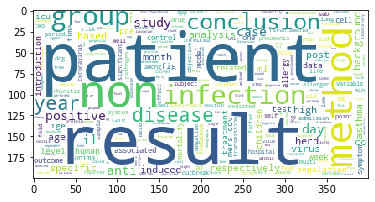

In [58]:
word_cloud = ''
for word in model_risk.wv.vocab.keys():
    word_cloud += " " + str(word)
    
wordcloud_eth = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud_eth.generate(word_cloud)
# Visualize the word cloud
plt.imshow(wordcloud_eth.to_image());

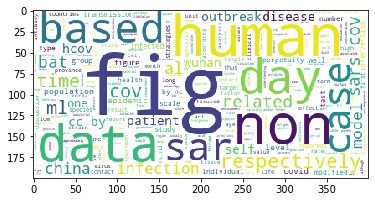

In [59]:
word_cloud = ''
for word in model_ethics.wv.vocab.keys():
    word_cloud += " " + str(word)
    
wordcloud_eth = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud_eth.generate(word_cloud)
# Visualize the word cloud
plt.imshow(wordcloud_eth.to_image());

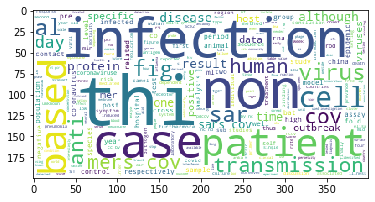

In [60]:
word_cloud = ''
for word in model_transmission.wv.vocab.keys():
    word_cloud += " " + str(word)
    
wordcloud_eth = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud_eth.generate(word_cloud)
# Visualize the word cloud
plt.imshow(wordcloud_eth.to_image());

Some of the NLP code is from the medium article [Multi-Class Text Classification with Doc2Vec & Logistic Regression](https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4)

## Conclusions

I tried some clustering but did not get great results, for next steps I would like to look into clustering or making some predictions based on the vectors produced by the doc2vec algorithm. The word clouds have a lot of similarity but there are a number of key differences which lead me to believe I'm on the right track. With more time I would like to further the refinement of the preprocessing perhaps try some stemming of the words. I would also like to perform some predictions.